### Testing GA Hyperparameter Tuning

Dependencies:
```
numpy
pandas 
matplotlib
sklearn
```

In [128]:
from genetic_algorithm import GeneticAlgorithm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay



##### Load data 

In [99]:
def get_analytics(y_test, y_pred):
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred, average='weighted')
   recall = recall_score(y_test, y_pred, average='weighted')
   f1 = f1_score(y_test, y_pred, average='weighted')
   cm = confusion_matrix(y_test, y_pred)
   report = classification_report(y_test, y_pred, output_dict=True)
   cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
   
   print("Accuracy: ", accuracy)
   print("Precision: ", precision)
   print("Recall: ", recall)
   print("F1 Score: ", f1)
   
   print("Classification Report:")
   print(report)
   cm_display.plot(cmap=plt.cm.Blues)
   plt.title("Confusion Matrix")
   plt.show()
   
   

In [100]:
def prepare_data(X, y):
   # Splits and scales the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   y_train_binary = np.where(y_train > np.median(y_train), 1, 0)
   y_test_binary = np.where(y_test > np.median(y_train), 1, 0)
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)
   return X_train_scaled, X_test_scaled, y_train_binary, y_test_binary
   
   
   
   
   

In [101]:
# Load Diabetes Data 
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

X_train_scaled, X_test_scaled, y_train_binary, y_test_binary = prepare_data(X, y)




In [102]:
from sklearn.datasets import load_iris
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV

## Testing

For testing, 3 different models were used
- Decision Trees
- SVM
- Logistic Regression

4 Different Hyperparameter tuning methods were used
- Our Genetic Algorithm Hyperparameter Tuning Method 
- Grid Search
- Randomized Search
- Halving Grid Search

For each model, across all of the hyperparameter tuning methods, the same set of parameters was used for each one and the same parameters were used for each genetic algorithm

### Decision Tree

In [ ]:
# Using the same params for Grid Search and Genetic Algorithm
# decision tree param space
param_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced'],
}

In [126]:
dt = DecisionTreeClassifier()


ga = GeneticAlgorithm(modelToTune=dt, 
                      param_space=param_space, 
                      verbose=0,
                      population_size=75,
                      generations=100,
                      mutation_prob=0.75,
                      crossover_prob=0.5,
                      cv=10,
                      scoring='accuracy'
                      ) 
start = time.time()
ga.run(X_train_scaled, y_train_binary)
end = time.time()
print(f"Genetic Algorithm took {end - start:.2f} seconds")
print(f"Best parameters found from Genetic Algorithm: {ga.best_params_}")
print(f"Best score from Genetic Algorithm: {ga.best_score_:.4f}")

Genetic Algorithm took 67.39 seconds
Best parameters found from Genetic Algorithm: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': 0.7, 'max_leaf_nodes': 30, 'splitter': 'best', 'class_weight': 'balanced'}
Best score from Genetic Algorithm: 0.7529


Accuracy:  0.7303370786516854
Precision:  0.7427605736731525
Recall:  0.7303370786516854
F1 Score:  0.7306094654409262
Classification Report:
{'0': {'precision': 0.8048780487804879, 'recall': 0.673469387755102, 'f1-score': 0.7333333333333333, 'support': 49.0}, '1': {'precision': 0.6666666666666666, 'recall': 0.8, 'f1-score': 0.7272727272727273, 'support': 40.0}, 'accuracy': 0.7303370786516854, 'macro avg': {'precision': 0.7357723577235773, 'recall': 0.736734693877551, 'f1-score': 0.7303030303030302, 'support': 89.0}, 'weighted avg': {'precision': 0.7427605736731525, 'recall': 0.7303370786516854, 'f1-score': 0.7306094654409262, 'support': 89.0}}


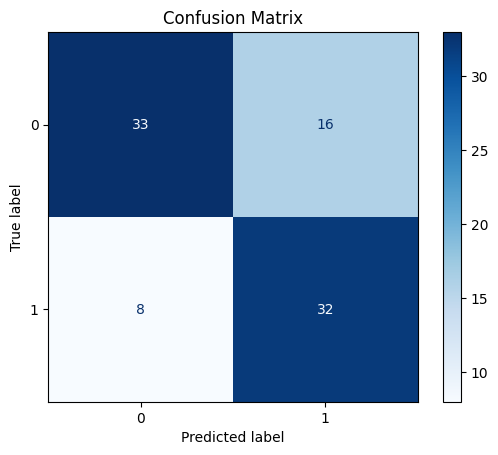

In [115]:
params = ga.best_params_
dt_clf = DecisionTreeClassifier(**params).fit(X_train_scaled, y_train_binary)
y_pred = dt_clf.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred)

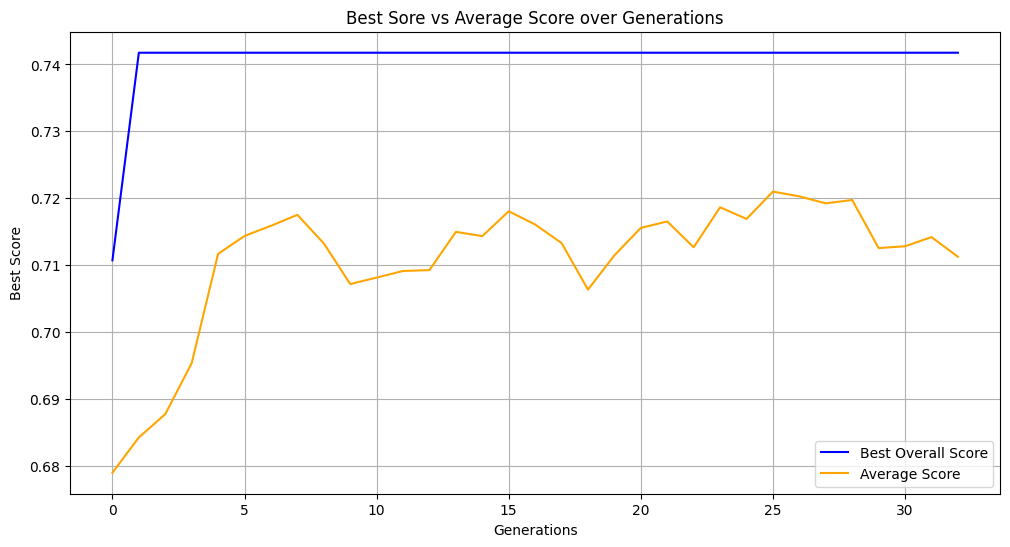

In [125]:
# Creating a graph of best scores over time 
ga_scores = ga.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Sore vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [ ]:
dt2 = DecisionTreeClassifier()

grid = GridSearchCV(dt2, param_space, cv=5, n_jobs=-1, scoring='accuracy')
start2 = time.time()
grid.fit(X_train_scaled, y_train_binary)
end2 = time.time()
print(f"Grid Search took {end2 - start2:.2f} seconds")
print(f"Best parameters from Grid Search: {grid.best_params_}")
print(f"Best score from Grid Search: {grid.best_score_:.4f}")

Grid Search took 1258.84 seconds
Best parameters from Grid Search: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 0.5, 'max_leaf_nodes': 20, 'min_samples_leaf': 13, 'min_samples_split': 10, 'splitter': 'best'}
Best score from Grid Search: 0.7764


Accuracy:  0.6853932584269663
Precision:  0.7080987642785395
Recall:  0.6853932584269663
F1 Score:  0.6839617818475137
Confusion Matrix:
[[29 20]
 [ 8 32]]
Classification Report:
{'0': {'precision': 0.7837837837837838, 'recall': 0.5918367346938775, 'f1-score': 0.6744186046511628, 'support': 49.0}, '1': {'precision': 0.6153846153846154, 'recall': 0.8, 'f1-score': 0.6956521739130435, 'support': 40.0}, 'accuracy': 0.6853932584269663, 'macro avg': {'precision': 0.6995841995841996, 'recall': 0.6959183673469388, 'f1-score': 0.6850353892821031, 'support': 89.0}, 'weighted avg': {'precision': 0.7080987642785395, 'recall': 0.6853932584269663, 'f1-score': 0.6839617818475137, 'support': 89.0}}


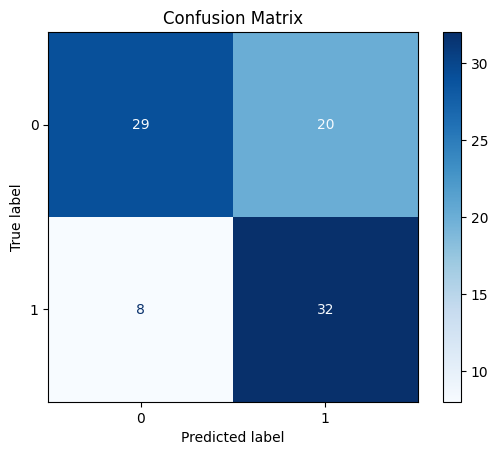

In [59]:
dt2 = grid.best_estimator_
y_pred2 = dt2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

##### Randomized Search

In [ ]:
dt3 = DecisionTreeClassifier()

rand = RandomizedSearchCV(dt3, param_space, n_iter=1000, cv=5, n_jobs=-1, scoring='accuracy')
start3 = time.time()
rand.fit(X_train_scaled, y_train_binary)
end3 = time.time()
print(f"Randomized Search took {end3 - start3:.2f} seconds")
print(f"Best parameters from Randomized Search: {rand.best_params_}")
print(f"Best score from Randomized Search: {rand.best_score_:.4f}")

Randomized Search took 0.17 seconds
Best parameters from Randomized Search: {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_leaf_nodes': 20, 'max_features': 0.7, 'max_depth': 11, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score from Randomized Search: 0.7281


Accuracy:  0.6966292134831461
Precision:  0.6956185720230664
Recall:  0.6966292134831461
F1 Score:  0.6938802225373623
Classification Report:
{'0': {'precision': 0.7037037037037037, 'recall': 0.7755102040816326, 'f1-score': 0.7378640776699029, 'support': 49.0}, '1': {'precision': 0.6857142857142857, 'recall': 0.6, 'f1-score': 0.64, 'support': 40.0}, 'accuracy': 0.6966292134831461, 'macro avg': {'precision': 0.6947089947089947, 'recall': 0.6877551020408164, 'f1-score': 0.6889320388349515, 'support': 89.0}, 'weighted avg': {'precision': 0.6956185720230664, 'recall': 0.6966292134831461, 'f1-score': 0.6938802225373623, 'support': 89.0}}


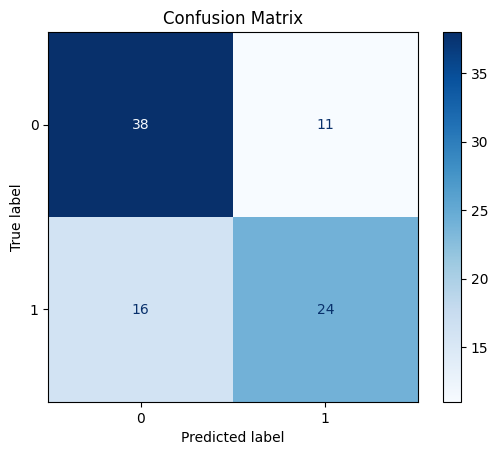

In [66]:
dt3 = rand.best_estimator_
y_pred3 = dt3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

##### Halving Grid Search

In [68]:
dt4 = DecisionTreeClassifier()
start4 = time.time()
halving_grid = HalvingGridSearchCV(dt4, param_space, cv=5, n_jobs=-1, scoring='accuracy')
halving_grid.fit(X_train_scaled, y_train_binary)
end4 = time.time()
print(f"Halving Grid Search took {end4 - start4:.2f} seconds")
print(f"Best parameters from Halving Grid Search: {halving_grid.best_params_}")
print(f"Best score from Halving Grid Search: {halving_grid.best_score_:.4f}")


Halving Grid Search took 1980.10 seconds
Best parameters from Halving Grid Search: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 4, 'splitter': 'random'}
Best score from Halving Grid Search: 0.8092


Accuracy:  0.6966292134831461
Precision:  0.7025593008739076
Recall:  0.6966292134831461
F1 Score:  0.6973967550050104
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.673469387755102, 'f1-score': 0.7096774193548387, 'support': 49.0}, '1': {'precision': 0.6444444444444445, 'recall': 0.725, 'f1-score': 0.6823529411764706, 'support': 40.0}, 'accuracy': 0.6966292134831461, 'macro avg': {'precision': 0.6972222222222222, 'recall': 0.699234693877551, 'f1-score': 0.6960151802656547, 'support': 89.0}, 'weighted avg': {'precision': 0.7025593008739076, 'recall': 0.6966292134831461, 'f1-score': 0.6973967550050104, 'support': 89.0}}


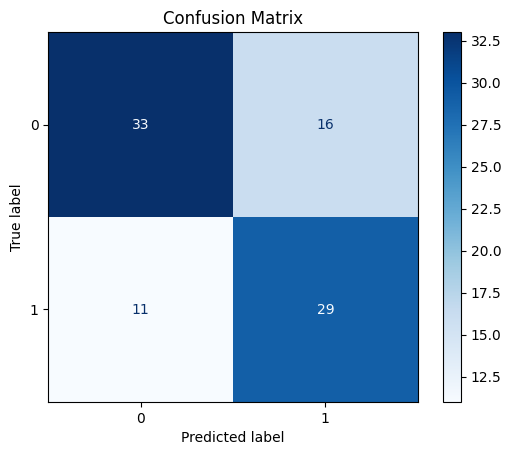

In [69]:
dt4 = halving_grid.best_estimator_
y_pred4 = dt4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)

### Support Vector Machine

In [103]:
from sklearn.svm import SVC

In [116]:
svm_param_space = {
    'C': list(np.logspace(-5, 3, 15)), 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': range(2, 10),  
    'coef0': list(np.linspace(0, 1, 5)), 
    'shrinking': [True, False], 
    'tol': list(np.logspace(-5, -1, 5))  
}

##### Genetic Algorithm Search

In [122]:
svm1 = SVC()
ga_svm = GeneticAlgorithm(modelToTune=svm1,
                          param_space=svm_param_space,
                           verbose=0,
                           population_size=75,
                           generations=100,
                           mutation_prob=0.75,
                           crossover_prob=0.5,
                           cv=10,
                           scoring='accuracy'
                           )
start5 = time.time()
ga_svm.run(X_train_scaled, y_train_binary)
end5 = time.time()
print(f"Genetic Algorithm for SVM took {end5 - start5:.2f} seconds")
print(f"Best parameters found from Genetic Algorithm for SVM: {ga_svm.best_params_}")
print(f"Best score from Genetic Algorithm for SVM: {ga_svm.best_score_:.4f}")

                           

Genetic Algorithm for SVM took 141.09 seconds
Best parameters found from Genetic Algorithm for SVM: {'C': np.float64(0.3727593720314938), 'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 5, 'coef0': np.float64(0.25), 'shrinking': True, 'tol': np.float64(0.01)}
Best score from Genetic Algorithm for SVM: 0.7529


Accuracy:  0.7303370786516854
Precision:  0.7297246366570089
Recall:  0.7303370786516854
F1 Score:  0.7285281942463561
Classification Report:
{'0': {'precision': 0.7358490566037735, 'recall': 0.7959183673469388, 'f1-score': 0.7647058823529411, 'support': 49.0}, '1': {'precision': 0.7222222222222222, 'recall': 0.65, 'f1-score': 0.6842105263157895, 'support': 40.0}, 'accuracy': 0.7303370786516854, 'macro avg': {'precision': 0.7290356394129979, 'recall': 0.7229591836734695, 'f1-score': 0.7244582043343653, 'support': 89.0}, 'weighted avg': {'precision': 0.7297246366570089, 'recall': 0.7303370786516854, 'f1-score': 0.7285281942463561, 'support': 89.0}}


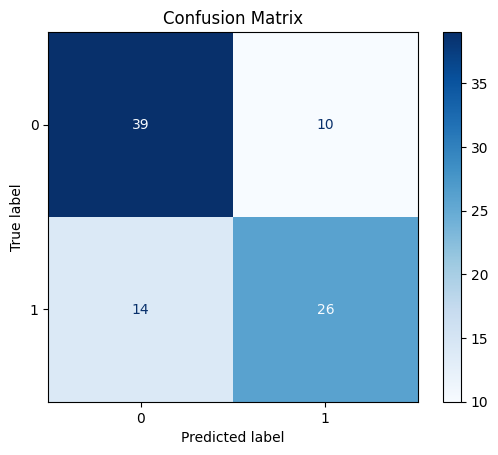

In [123]:
params = ga_svm.best_params_
svm_clf = SVC(**params).fit(X_train_scaled, y_train_binary)
y_pred = svm_clf.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred)

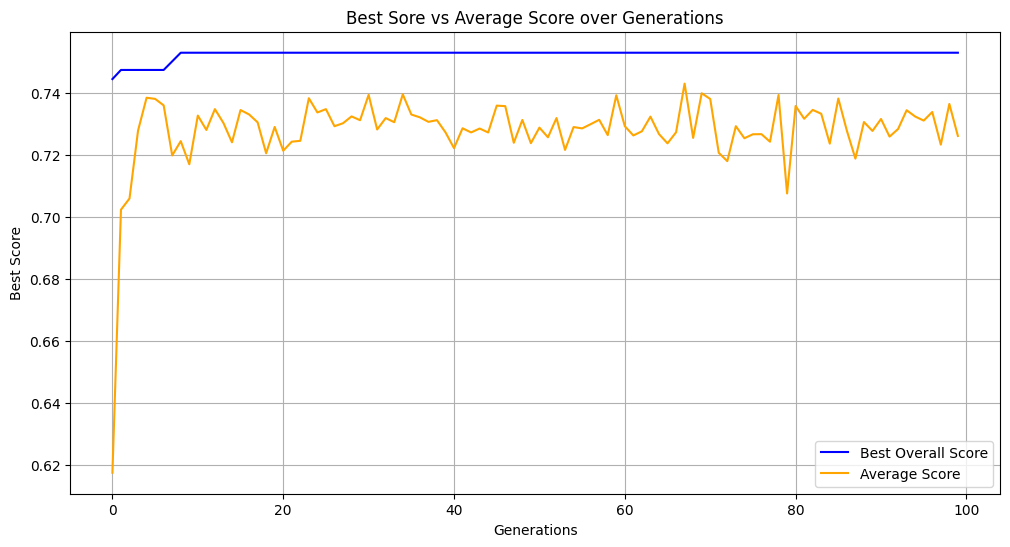

In [124]:
# Creating a graph of best scores over time 
ga_scores = ga_svm.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Sore vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [70]:
svm2 = SVC()
grid_svm = GridSearchCV(svm2, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start6 = time.time()
grid_svm.fit(X_train_scaled, y_train_binary)
end6 = time.time()
print(f"Grid Search for SVM took {end6 - start6:.2f} seconds")
print(f"Best parameters from Grid Search for SVM: {grid_svm.best_params_}")
print(f"Best score from Grid Search for SVM: {grid_svm.best_score_:.4f}")


Grid Search for SVM took 907.62 seconds
Best parameters from Grid Search for SVM: {'C': 0.007196856730011514, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': 0.1}
Best score from Grid Search for SVM: 0.7591


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


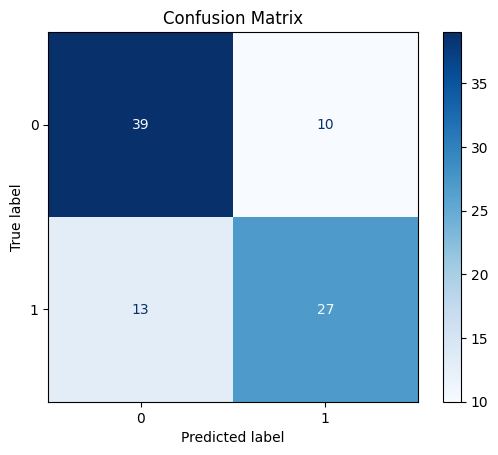

In [71]:
svm2 = grid_svm.best_estimator_
y_pred2 = svm2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

##### Randomized Search

In [118]:
svm3 = SVC()
rand_svm = RandomizedSearchCV(svm3, svm_param_space, n_iter=1000, cv=5, n_jobs=-1, scoring='accuracy')
start7 = time.time()
rand_svm.fit(X_train_scaled, y_train_binary)
end7 = time.time()
print(f"Randomized Search for SVM took {end7 - start7:.2f} seconds")
print(f"Best parameters from Randomized Search for SVM: {rand_svm.best_params_}")
print(f"Best score from Randomized Search for SVM: {rand_svm.best_score_:.4f}")

Randomized Search for SVM took 23.19 seconds
Best parameters from Randomized Search for SVM: {'tol': 0.1, 'shrinking': False, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'coef0': 0.5, 'C': 0.007196856730011514}
Best score from Randomized Search for SVM: 0.7591


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


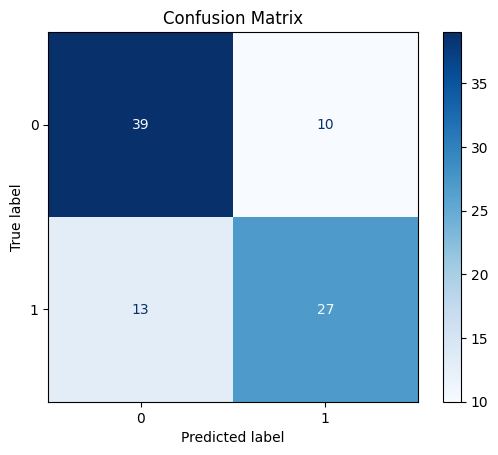

In [119]:
svm3 = rand_svm.best_estimator_
y_pred3 = svm3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

##### Halving Grid Search

In [74]:
svm4 = SVC()
halving_grid_svm = HalvingGridSearchCV(svm4, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start8 = time.time()
halving_grid_svm.fit(X_train_scaled, y_train_binary)
end8 = time.time()
print(f"Halving Grid Search for SVM took {end8 - start8:.2f} seconds")
print(f"Best parameters from Halving Grid Search for SVM: {halving_grid_svm.best_params_}")
print(f"Best score from Halving Grid Search for SVM: {halving_grid_svm.best_score_:.4f}")

Halving Grid Search for SVM took 64.28 seconds
Best parameters from Halving Grid Search for SVM: {'C': 1.389495494373136, 'coef0': 0.0, 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.1}
Best score from Halving Grid Search for SVM: 0.7410


Accuracy:  0.7640449438202247
Precision:  0.7636358398156152
Recall:  0.7640449438202247
F1 Score:  0.7637432495916353
Classification Report:
{'0': {'precision': 0.78, 'recall': 0.7959183673469388, 'f1-score': 0.7878787878787878, 'support': 49.0}, '1': {'precision': 0.7435897435897436, 'recall': 0.725, 'f1-score': 0.7341772151898734, 'support': 40.0}, 'accuracy': 0.7640449438202247, 'macro avg': {'precision': 0.7617948717948718, 'recall': 0.7604591836734693, 'f1-score': 0.7610280015343307, 'support': 89.0}, 'weighted avg': {'precision': 0.7636358398156152, 'recall': 0.7640449438202247, 'f1-score': 0.7637432495916353, 'support': 89.0}}


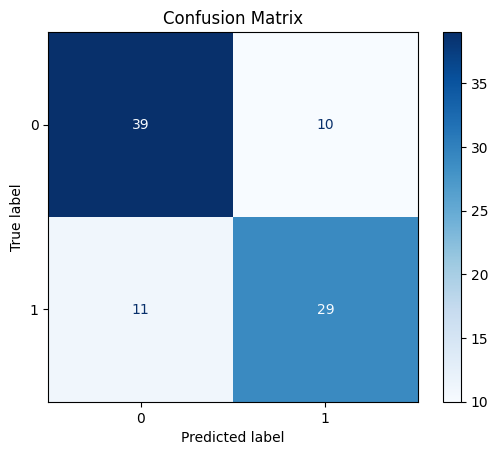

In [75]:
svm4 = halving_grid_svm.best_estimator_
y_pred4 = svm4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)

### Logistic Regression

Note: L1 penalty is not compatible with the GridSearchCV

In [82]:
from sklearn.linear_model import LogisticRegression
from genetic_algorithm import logGA

In [100]:
logreg_param_space = {
    'C': list(np.logspace(-4, 4, 20)),
    'penalty': ['l1', 'l2'],
    'solver': {  
        'l1': ['liblinear', 'saga'],
        'l2': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
    },
    'max_iter': list(range(100, 2001, 100)),
    'tol': [1e-4, 1e-5, 1e-6],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}

# Other searches need single values in lists
logreg_param_space2 = {
    'C': list(np.logspace(-4, 4, 20)),
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': list(range(100, 2001, 100)),
    'tol': [1e-4, 1e-5, 1e-6],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}


##### Genetic Algorithm Search

In [ ]:
lr1 = LogisticRegression()
ga_logreg = logGA(
      modelToTune=lr1,
      param_space=logreg_param_space,
      verbose=0,
      population_size=75,
      generations=100,
      mutation_prob=0.75,
      crossover_prob=0.5,
      cv=10,
      scoring='accuracy'
)
start9 = time.time()
ga_logreg.run(X_train_scaled, y_train_binary)
end9 = time.time()
print(f"Genetic Algorithm for Logistic Regression took {end9 - start9:.2f} seconds")
print(f"Best parameters found from Genetic Algorithm for Logistic Regression: {ga_logreg.best_params_}")
print(f"Best score from Genetic Algorithm for Logistic Regression: {ga_logreg.best_score_:.4f}")

Generation 1/10000 - Best: -inf - Avg: -inf
Generation 2/10000 - Best: -inf - Avg: -inf
Generation 3/10000 - Best: -inf - Avg: -inf
Generation 4/10000 - Best: -inf - Avg: -inf
Generation 5/10000 - Best: -inf - Avg: -inf
Generation 6/10000 - Best: -inf - Avg: -inf
Generation 7/10000 - Best: -inf - Avg: -inf
Generation 8/10000 - Best: -inf - Avg: -inf
Generation 9/10000 - Best: -inf - Avg: -inf
Generation 10/10000 - Best: -inf - Avg: -inf
Generation 11/10000 - Best: -inf - Avg: -inf
Generation 12/10000 - Best: -inf - Avg: -inf
Generation 13/10000 - Best: -inf - Avg: -inf
Generation 14/10000 - Best: -inf - Avg: -inf
Generation 15/10000 - Best: -inf - Avg: -inf
Generation 16/10000 - Best: -inf - Avg: -inf
Generation 17/10000 - Best: -inf - Avg: -inf
Generation 18/10000 - Best: -inf - Avg: -inf
Generation 19/10000 - Best: -inf - Avg: -inf
Generation 20/10000 - Best: -inf - Avg: -inf
Generation 21/10000 - Best: -inf - Avg: -inf
Generation 22/10000 - Best: -inf - Avg: -inf
Generation 23/10000

Accuracy:  0.7640449438202247
Precision:  0.7636244714896401
Recall:  0.7640449438202247
F1 Score:  0.7629526997643584
Classification Report:
{'0': {'precision': 0.7692307692307693, 'recall': 0.8163265306122449, 'f1-score': 0.7920792079207921, 'support': 49.0}, '1': {'precision': 0.7567567567567568, 'recall': 0.7, 'f1-score': 0.7272727272727273, 'support': 40.0}, 'accuracy': 0.7640449438202247, 'macro avg': {'precision': 0.7629937629937631, 'recall': 0.7581632653061224, 'f1-score': 0.7596759675967597, 'support': 89.0}, 'weighted avg': {'precision': 0.7636244714896401, 'recall': 0.7640449438202247, 'f1-score': 0.7629526997643584, 'support': 89.0}}


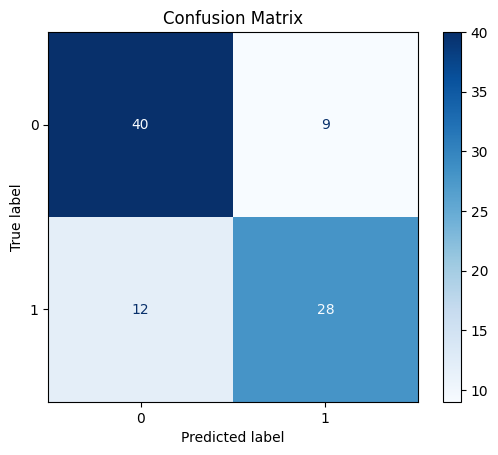

In [93]:
params = ga_logreg.best_params_
logreg_clf = LogisticRegression(**params).fit(X_train_scaled, y_train_binary)
y_pred = logreg_clf.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred)

In [127]:
# Creating a graph of best scores over time 
ga_scores = ga_logreg.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Sore vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

NameError: name 'ga_logreg' is not defined

##### Grid Search

In [101]:
lr2 = LogisticRegression()
grid_logreg = GridSearchCV(lr2, logreg_param_space2, cv=5, n_jobs=-1, scoring='accuracy')
start10 = time.time()
grid_logreg.fit(X_train_scaled, y_train_binary)
end10 = time.time()
print(f"Grid Search for Logistic Regression took {end10 - start10:.2f} seconds")
print(f"Best parameters from Grid Search for Logistic Regression: {grid_logreg.best_params_}")
print(f"Best score from Grid Search for Logistic Regression: {grid_logreg.best_score_:.4f}")

Grid Search for Logistic Regression took 17.14 seconds
Best parameters from Grid Search for Logistic Regression: {'C': 0.012742749857031334, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Best score from Grid Search for Logistic Regression: 0.7562


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


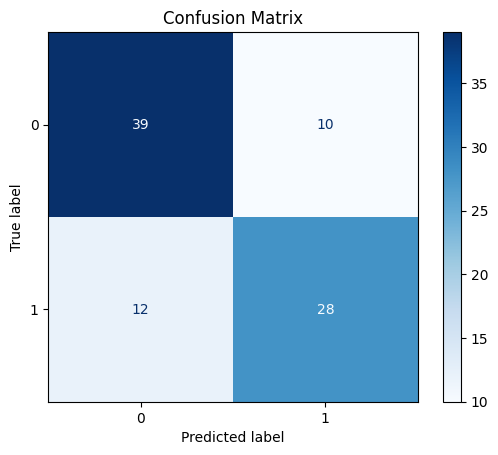

In [102]:
lr2 = grid_logreg.best_estimator_
y_pred2 = lr2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

##### Randomized Search

In [104]:
lr3 = LogisticRegression()
rand_logreg = RandomizedSearchCV(lr3, logreg_param_space2, n_iter=1000, cv=5, n_jobs=-1, scoring='accuracy')
start11 = time.time()
rand_logreg.fit(X_train_scaled, y_train_binary)
end11 = time.time()
print(f"Randomized Search for Logistic Regression took {end11 - start11:.2f} seconds")
print(f"Best parameters from Randomized Search for Logistic Regression: {rand_logreg.best_params_}")
print(f"Best score from Randomized Search for Logistic Regression: {rand_logreg.best_score_:.4f}")

Randomized Search for Logistic Regression took 1.98 seconds
Best parameters from Randomized Search for Logistic Regression: {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1100, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.012742749857031334}
Best score from Randomized Search for Logistic Regression: 0.7562


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


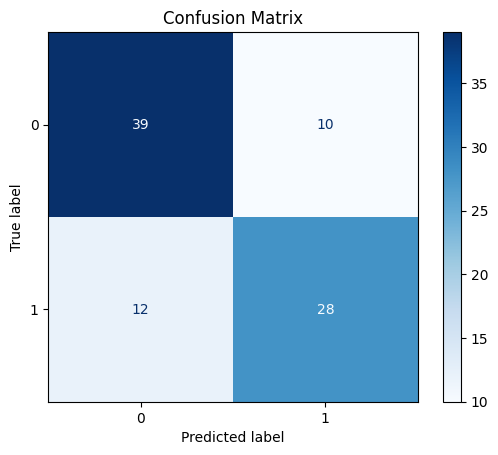

In [105]:
lr3 = rand_logreg.best_estimator_
y_pred3 = lr3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

##### Halving Grid Search

In [107]:
lr4 = LogisticRegression()
halving_grid_logreg = HalvingGridSearchCV(lr4, logreg_param_space2, cv=5, n_jobs=-1, scoring='accuracy')
start12 = time.time()
halving_grid_logreg.fit(X_train_scaled, y_train_binary)
end12 = time.time()
print(f"Halving Grid Search for Logistic Regression took {end12 - start12:.2f} seconds")
print(f"Best parameters from Halving Grid Search for Logistic Regression: {halving_grid_logreg.best_params_}")
print(f"Best score from Halving Grid Search for Logistic Regression: {halving_grid_logreg.best_score_:.4f}")

Halving Grid Search for Logistic Regression took 13.80 seconds
Best parameters from Halving Grid Search for Logistic Regression: {'C': 0.012742749857031334, 'class_weight': None, 'fit_intercept': True, 'max_iter': 1800, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-06}
Best score from Halving Grid Search for Logistic Regression: 0.7302


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


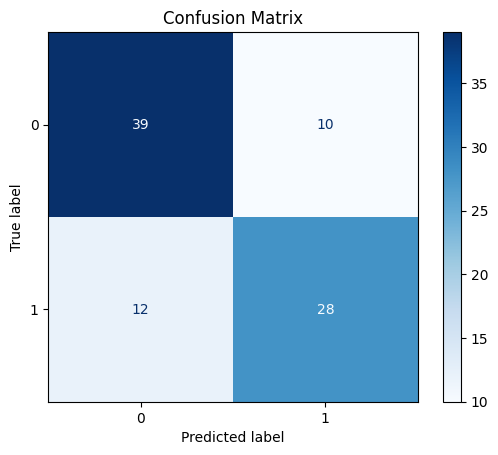

In [108]:
lr4 = halving_grid_logreg.best_estimator_
y_pred4 = lr4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)